# Notebook to make a cow' race classification for Angus, Hereford and no pure race

Comamand to execute a local instance of jupyter notebooks so it can be used with colab

In [ ]:
#command in cmd to run a jupyter instance to connect colab locally 
#jupyter notebook --NotebookApp.allow_origin="https://colab.research.google.com" --port=8888 --NotebookApp.port_retries=0

Imports

In [ ]:
import tensorflow as tf  #version 2.10.0 
import keras
import numpy as np
from tensorflow.keras import layers
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import os

Constants

In [ ]:
height=224
width=224
img_dim_target=(height, width, 3)
root='D:/Vacas/'  #change it to the directory you'll use to store images
raw_dir=root+'webp/'
post_dir=root+'png/'
batch_size=32
files_to_predict=root+'to_predict/'

Create folder's (run the first time)

In [ ]:
# if not os.path.exists(root):
#     os.makedirs(raw_dir+'Angus')
#     os.makedirs(raw_dir+'Hereford')
#     os.makedirs(raw_dir+'NoRace')
#     os.makedirs(post_dir+'Angus')
#     os.makedirs(post_dir+'Hereford')
#     os.makedirs(post_dir+'NoRace')
#     os.makedirs(files_to_predict)
#     os.makedirs(root+'models')

Handling webp or another image format 

In [ ]:
#Changing extension of images from webp to png to make it easier to handle with TF


# Angus_files=(os.listdir(raw_dir+ "Angus"))
# Hereford_files=(os.listdir(raw_dir+ "Hereford"))
# NoRace_files=(os.listdir(raw_dir+ "NoRace"))

# angus_quantity=0
# for image in Angus_files:
#   im=Image.open(raw_dir+"Angus/"+image).convert("RGB")
#   im.save(post_dir+"Angus/angus"+str(angus_quantity)+".png", "png")
#   angus_quantity+=1

# hereford_quantity=0
# for image in Hereford_files:
#   im=Image.open(raw_dir+"Hereford/"+image).convert("RGB")
#   im.save(post_dir+"Hereford/hereford"+str(hereford_quantity)+".png", "png")
#   hereford_quantity+=1

# norace_quantity=0
# for image in NoRace_files:
#   im=Image.open(raw_dir+"NoRace/"+image).convert("RGB")
#   im.save(post_dir+"NoRace/norace"+str(norace_quantity)+".png", "png")
#   norace_quantity+=1

# total_images=hereford_quantity+angus_quantity+norace_quantity
# print("Dataset: \n  Hereford: ",hereford_quantity, "\n  Angus: ", angus_quantity, "\n  NoRace:", norace_quantity, "\n  Total:", total_images)

Importing data to the model  (it is using 60% images for training, 20% for validating and 20% for testing )

In [ ]:
training_data=tf.keras.utils.image_dataset_from_directory(
    post_dir,
    shuffle=True,
    validation_split=0.4,
    image_size=(height, width),
    label_mode='categorical',
    class_names=['Angus','Hereford','NoRace'],
    subset='training',
    seed=123
)
validation_data=tf.keras.utils.image_dataset_from_directory(
    post_dir,
    shuffle=True,
    validation_split=0.4,
    image_size=(height, width),
    label_mode='categorical',
    class_names=['Angus','Hereford','NoRace'],
    subset='validation',
    seed=1234 
)

#test_data is to keep some untrained fresh data to test the model
validation_data, test_data = tf.keras.utils.split_dataset (validation_data, 0.5, 0.5, shuffle=True, seed=12345)

Plot some training data 

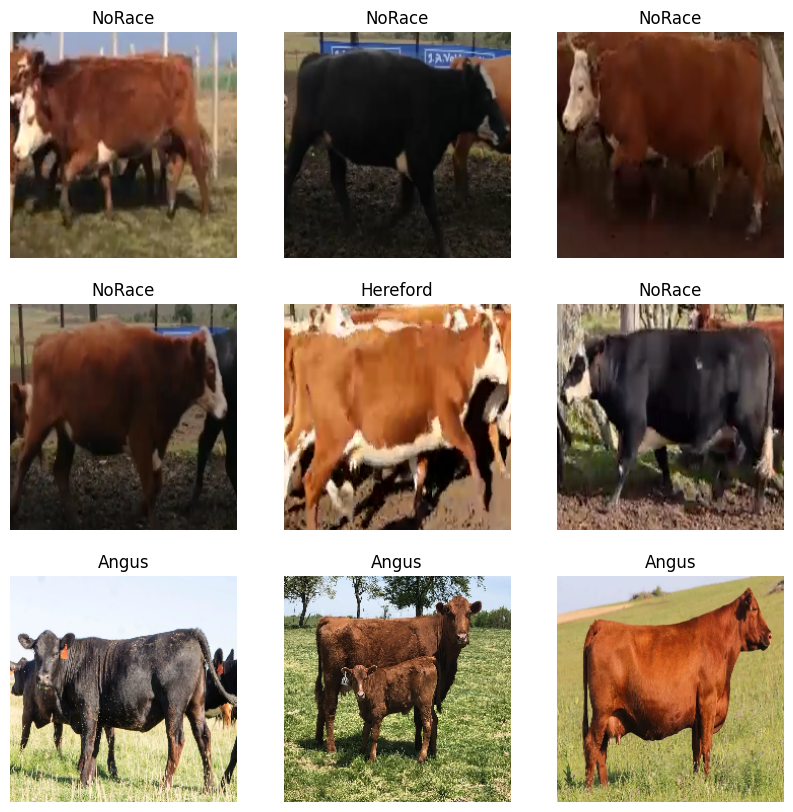

In [ ]:
classes = training_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[np.argmax(labels[i])])
    plt.axis("off")

Data augmenter function

In [ ]:
#it there is overfit try with different data augmentation
def data_augmenter():
  data_augmenter=tf.keras.Sequential()
  data_augmenter.add(layers.RandomFlip("horizontal"))
  data_augmenter.add(layers.RandomRotation((-0.06, 0.06)))
  return data_augmenter

Callback

In [ ]:
class Callback1(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch, logs={}):
    if logs.get('accuracy') is not None and logs.get('accuracy')> 0.99:
      print("\n Model has reached 99% accuracy")
      self.model.stop_training= True

Defining the Neural Network architecture with transfer learning (MobileNetV2)

In [ ]:
def first_model(image_shape=img_dim_target, data_augmentation=data_augmenter()):

  #setting the model which will be used to transfer its learning
  base_model=tf.keras.applications.MobileNetV2(input_shape=img_dim_target,
                                             include_top=False,
                                             weights='imagenet'
                                             )
  base_model.trainable= False

  inputs= tf.keras.Input(shape=image_shape)

  x=data_augmentation(inputs)

  x=tf.keras.applications.mobilenet_v2.preprocess_input(x)
  x=base_model(x, training=False)

  x = tf.keras.layers.GlobalAveragePooling2D()(x) 
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)

  return model

Instanciate model (do not worry about warnings)

In [ ]:
callback=Callback1()

model=first_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'],)

history=model.fit(training_data, validation_data=validation_data,epochs=15, callbacks=[callback]) 

Improve the model by training some previous layers

In [ ]:
for layer in model.layers[len(model.layers)-10:]:
  layer.trainable=True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine=model.fit(training_data,validation_data=validation_data,epochs=30, initial_epoch=history.epoch[-1], callbacks=[callback])

tf.keras.models.save_model(model,root+ 'models', overwrite=True)

Test accuracy in the test set

In [ ]:
predictions=model.evaluate(test_data)

Test your own images

In [ ]:
to_predict=os.listdir(files_to_predict)
model= tf.keras.models.load_model(root+ 'models')
class_names=['Angus','Hereford','NoRace']

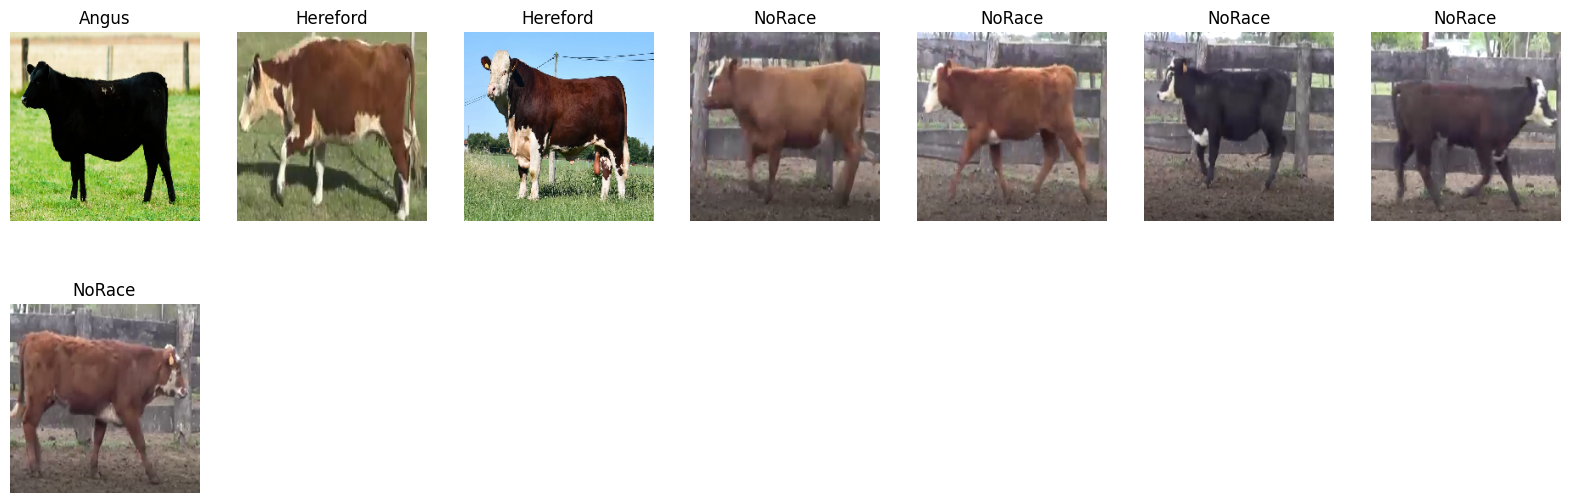

In [ ]:
counter=0
plt.figure(figsize=(20, 10))
rows=  np.ceil(len(to_predict)/7)

for fn in to_predict:
  path= files_to_predict +str(fn)

  image=  tf.keras.utils.load_img(path, target_size=(height,width))
  x =  tf.keras.utils.img_to_array(image)
  x = np.expand_dims(x, axis=0)
  x = np.vstack([x])
  classes = model.predict(x, batch_size=1, verbose=0)

  preds_classes = np.argmax(classes, axis=-1)
  
  ax = plt.subplot(3, 7, counter + 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(class_names[preds_classes[0]])

  counter+=1

Things to improve:

* Make a cell applying data augmentation in training to see it in action
* Make a cell to see the process of convolutions through examples